# Company Bankruptcy prediction

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import classification_report,accuracy_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.feature_selection import VarianceThreshold


%matplotlib inline



In [ ]:
#PLEASE CHECK LOCATION BEFORE RUNNING
df = pd.read_csv("data.csv")
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

# **Data Profiling**

In [ ]:
#Shape of the dataset
df.shape

(6819, 96)

In [ ]:
#Statistical summary of data
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,1.328641e+06,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.886823,0.008783,...,0.522273,0.124095,3.592902e+06,3.715999e+07,0.090673,0.353828,0.277395,5.580680e+07,0.761599,0.735817,0.331410,5.416004e+07,0.934733,0.002549,0.029184,1.195856e+09,2.163735e+09,0.594006,2.471977e+09,0.671531,1.220121e+06,0.761599,0.331410,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.001173,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686

In [ ]:
#feature information
pd.DataFrame(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

""


All the features are numeric. No need of any encoding techniques

In [ ]:
data_mean = np.mean(df, axis=0)

variance = np.var(df/data_mean, axis=0)
var_df = pd.DataFrame(variance,columns=['variance'])
var_df.sort_values(by='variance').style.background_gradient(sns.color_palette("flare", as_cmap=True))

,variance
Net Income Flag,0.000000
Operating Profit Growth Rate,0.000161
Operating Profit Rate,0.000170
Cash Flow to Sales,0.000193
Working capitcal Turnover Rate,0.000227
Working Capital/Equity,0.000252
Pre-tax net Interest Rate,0.000261
Continuous interest rate (after tax),0.000263
After-tax net Interest Rate,0.000283
Net Income to Stockholder's Equity,0.000299


In [ ]:
#Checking for missing values
c=0
for col in df.columns:
    null_values_count = df[col].isnull().sum()
    if null_values_count > 0:
        c=c+1
        print(col,null_values_count)

if c==0:
    print("No missing values found in the dataset")

No missing values found in the dataset


Text(0, 0.5, 'No. of Comapnies')

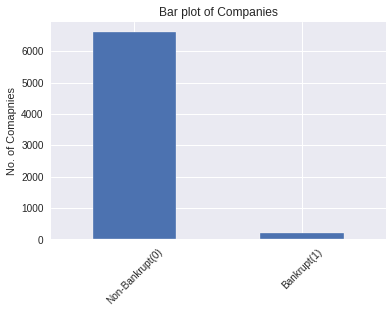

In [ ]:
df["Bankrupt?"].value_counts().plot(kind="bar")
plt.title("Bar plot of Companies")
plt.xticks([0,1],["Non-Bankrupt(0)","Bankrupt(1)"],rotation = 45)
plt.ylabel("No. of Comapnies")

In [ ]:
X=df.drop(['Bankrupt?'],axis=1)
y=df['Bankrupt?']

# Feature Selection

In [ ]:
var_thres = VarianceThreshold(3.0)
var_thres.fit(X)

VarianceThreshold(threshold=3.0)

In [ ]:
required_features = [col for col in X.columns if col in X.columns[var_thres.get_support()]]
print(required_features)

[' Operating Expense Rate', ' Research and development expense rate', ' Interest-bearing debt interest rate', ' Revenue Per Share (Yuan ¥)', ' Total Asset Growth Rate', ' Net Value Growth Rate', ' Current Ratio', ' Quick Ratio', ' Total debt/Total net worth', ' Accounts Receivable Turnover', ' Average Collection Days', ' Inventory Turnover Rate (times)', ' Fixed Assets Turnover Frequency', ' Revenue per person', ' Allocation rate per person', ' Quick Assets/Current Liability', ' Cash/Current Liability', ' Inventory/Current Liability', ' Long-term Liability to Current Assets', ' Current Asset Turnover Rate', ' Quick Asset Turnover Rate', ' Cash Turnover Rate', ' Fixed Assets to Assets', ' Total assets to GNP price']


In [ ]:
len(required_features)

24

Observation:
* 24 features are selected. Features having variance of less than 3.0 has been dropped

In [ ]:
df_v1 = df[required_features]
df_v1.head()

,Operating Expense Rate,Research and development expense rate,Interest-bearing debt interest rate,Revenue Per Share (Yuan ¥),Total Asset Growth Rate,Net Value Growth Rate,Current Ratio,Quick Ratio,Total debt/Total net worth,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Revenue per person,Allocation rate per person,Quick Assets/Current Liability,Cash/Current Liability,Inventory/Current Liability,Long-term Liability to Current Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Fixed Assets to Assets,Total assets to GNP price
0,1.256969e-04,0.0,0.000725,0.017560,4.980000e+09,0.000327,0.002259,0.001208,0.021266,0.001814,0.003487,1.820926e-04,1.165007e-04,0.034164,0.037135,0.001997,1.473360e-04,0.001036,0.025592,7.010000e+08,6.550000e+09,4.580000e+08,0.424206,0.009219
1,2.897851e-04,0.0,0.000647,0.021144,6.110000e+09,0.000443,0.006016,0.004039,0.012502,0.001286,0.004917,9.360000e+09,7.190000e+08,0.006889,0.012335,0.004136,1.383910e-03,0.005210,0.023947,1.065198e-04,7.700000e+09,2.490000e+09,0.468828,0.008323
2,2.361297e-04,25500000.0,0.000790,0.005944,7.280000e+09,0.000396,0.011543,0.005348,0.021248,0.001495,0.004227,6.500000e+07,2.650000e+09,0.028997,0.141016,0.006302,5.340000e+09,0.013879,0.003715,1.791094e-03,1.022676e-03,7.610000e+08,0.276179,0.040003
3,1.078888e-04,0.0,0.000449,0.014368,4.880000e+09,0.000382,0.004194,0.002896,0.009572,0.001966,0.003215,7.130000e+09,9.150000e+09,0.015463,0.021320,0.002961,1.010646e-03,0.003540,0.022165,8.140000e+09,6.050000e+09,2.030000e+09,0.559144,0.003252
4,7.890000e+09,0.0,0.000686,0.029690,5.510000e+09,0.000439,0.006022,0.003727,0.005150,0.001449,0.004367,1.633674e-04,2.935211e-04,0.058111,0.023988,0.004275,6.804636e-04,0.004869,0.000000,6.680000e+09,5.050000e+09,8.240000e+08,0.309555,0.003878


In [ ]:
#Checking for multicollinearity
df_v1_corr = df_v1.corr()
df_v1_corr.style.background_gradient(cmap=sns.diverging_palette(600, 10, as_cmap=True))

,Operating Expense Rate,Research and development expense rate,Interest-bearing debt interest rate,Revenue Per Share (Yuan ¥),Total Asset Growth Rate,Net Value Growth Rate,Current Ratio,Quick Ratio,Total debt/Total net worth,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Revenue per person,Allocation rate per person,Quick Assets/Current Liability,Cash/Current Liability,Inventory/Current Liability,Long-term Liability to Current Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Fixed Assets to Assets,Total assets to GNP price
Operating Expense Rate,1.000000,-0.060386,-0.006011,-0.015838,0.014168,-0.008456,-0.007464,0.017687,-0.016164,-0.028331,-0.007935,-0.129214,-0.055160,-0.010492,-0.009231,-0.012904,0.024258,-0.011448,0.001729,0.170776,0.153936,0.040730,-0.007464,-0.025524
Research and development expense rate,-0.060386,1.000000,0.000656,-0.019291,0.023189,-0.010300,-0.009092,-0.025702,-0.019292,-0.034508,-0.028471,0.001366,0.016872,-0.012780,-0.028073,-0.015717,-0.042133,-0.023691,0.008636,-0.046460,-0.034643,0.070369,-0.009092,-0.020166
Interest-bearing debt interest rate,-0.006011,0.000656,1.000000,-0.003904,-0.018700,0.013614,-0.001840,-0.005201,-0.003984,-0.006983,0.016496,0.007713,-0.036213,-0.002586,0.024254,0.055143,-0.011063,0.011240,0.006090,-0.009759,-0.026821,-0.019243,-0.001840,-0.007519
Revenue Per Share (Yuan ¥),-0.015838,-0.019291,-0.003904,1.000000,-0.010670,-0.000353,-0.000311,-0.000880,0.029592,0.264346,-0.000985,-0.011734,-0.010462,0.275742,-0.000982,-0.000538,-0.001871,0.037494,-0.002441,-0.010894,-0.016476,-0.021618,-0.000311,-0.001272
Total Asset Growth Rate,0.014168,0.023189,-0.018700,-0.010670,1.000000,-0.008688,0.006779,-0.013451,-0.012469,-0.030866,-0.035608,0.030277,0.009155,-0.017423,-0.010750,-0.002528,0.006808,-0.011164,0.016918,0.000739,0.032340,0.064419,0.006570,-0.038909
Net Value Growth Rate,-0.008456,-0.010300,0.013614,-0.000353,-0.008688,1.000000,-0.000166,-0.000470,-0.000360,-0.000631,-0.000526,-0.009009,0.036004,-0.000234,-0.000524,0.075915,-0.000999,-0.001316,-0.001303,0.008879,0.006129,-0.002081,-0.000166,-0.000679
Current Ratio,-0.007464,-0.009092,-0.001840,-0.000311,0.006779,-0.000166,1.000000,-0.000415,-0.000318,-0.000557,-0.000464,-0.007943,-0.004931,-0.000206,-0.000463,-0.000254,-0.000882,-0.001161,-0.001150,-0.002240,-0.007291,-0.003635,-0.000147,-0.000599
Quick Ratio,0.017687,-0.025702,-0.005201,-0.000880,-0.013451,-0.000470,-0.000415,1.000000,-0.000898,-0.001574,0.016026,-0.019058,0.001797,-0.000583,-0.001309,-0.000717,0.151987,-0.003283,-0.003252,-0.014514,0.007069,-0.022126,-0.000415,-0.001694
Total debt/Total net worth,-0.016164,-0.019292,-0.003984,0.029592,-0.012469,-0.000360,-0.000318,-0.000898,1.000000,0.008627,-0.001005,-0.013441,0.016062,-0.000446,-0.001002,-0.000549,-0.001910,-0.002515,-0.002491,-0.011118,-0.016815,-0.016561,-0.000318,-0.001298
Accounts Receivable Turnover,-0.028331,-0.034508,-0.006983,0.264346,-0.030866,-0.000631,-0.000557,-0.001574,0.008627,1.000000,-0.001762,-0.013201,-0.001709,0.032398,-0.001757,-0.000962,0.036912,0.048829,-0.001859,-0.019486,-0.029472,-0.022508,-0.000557,0.113731


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8618009b10>,
      dtype=object)

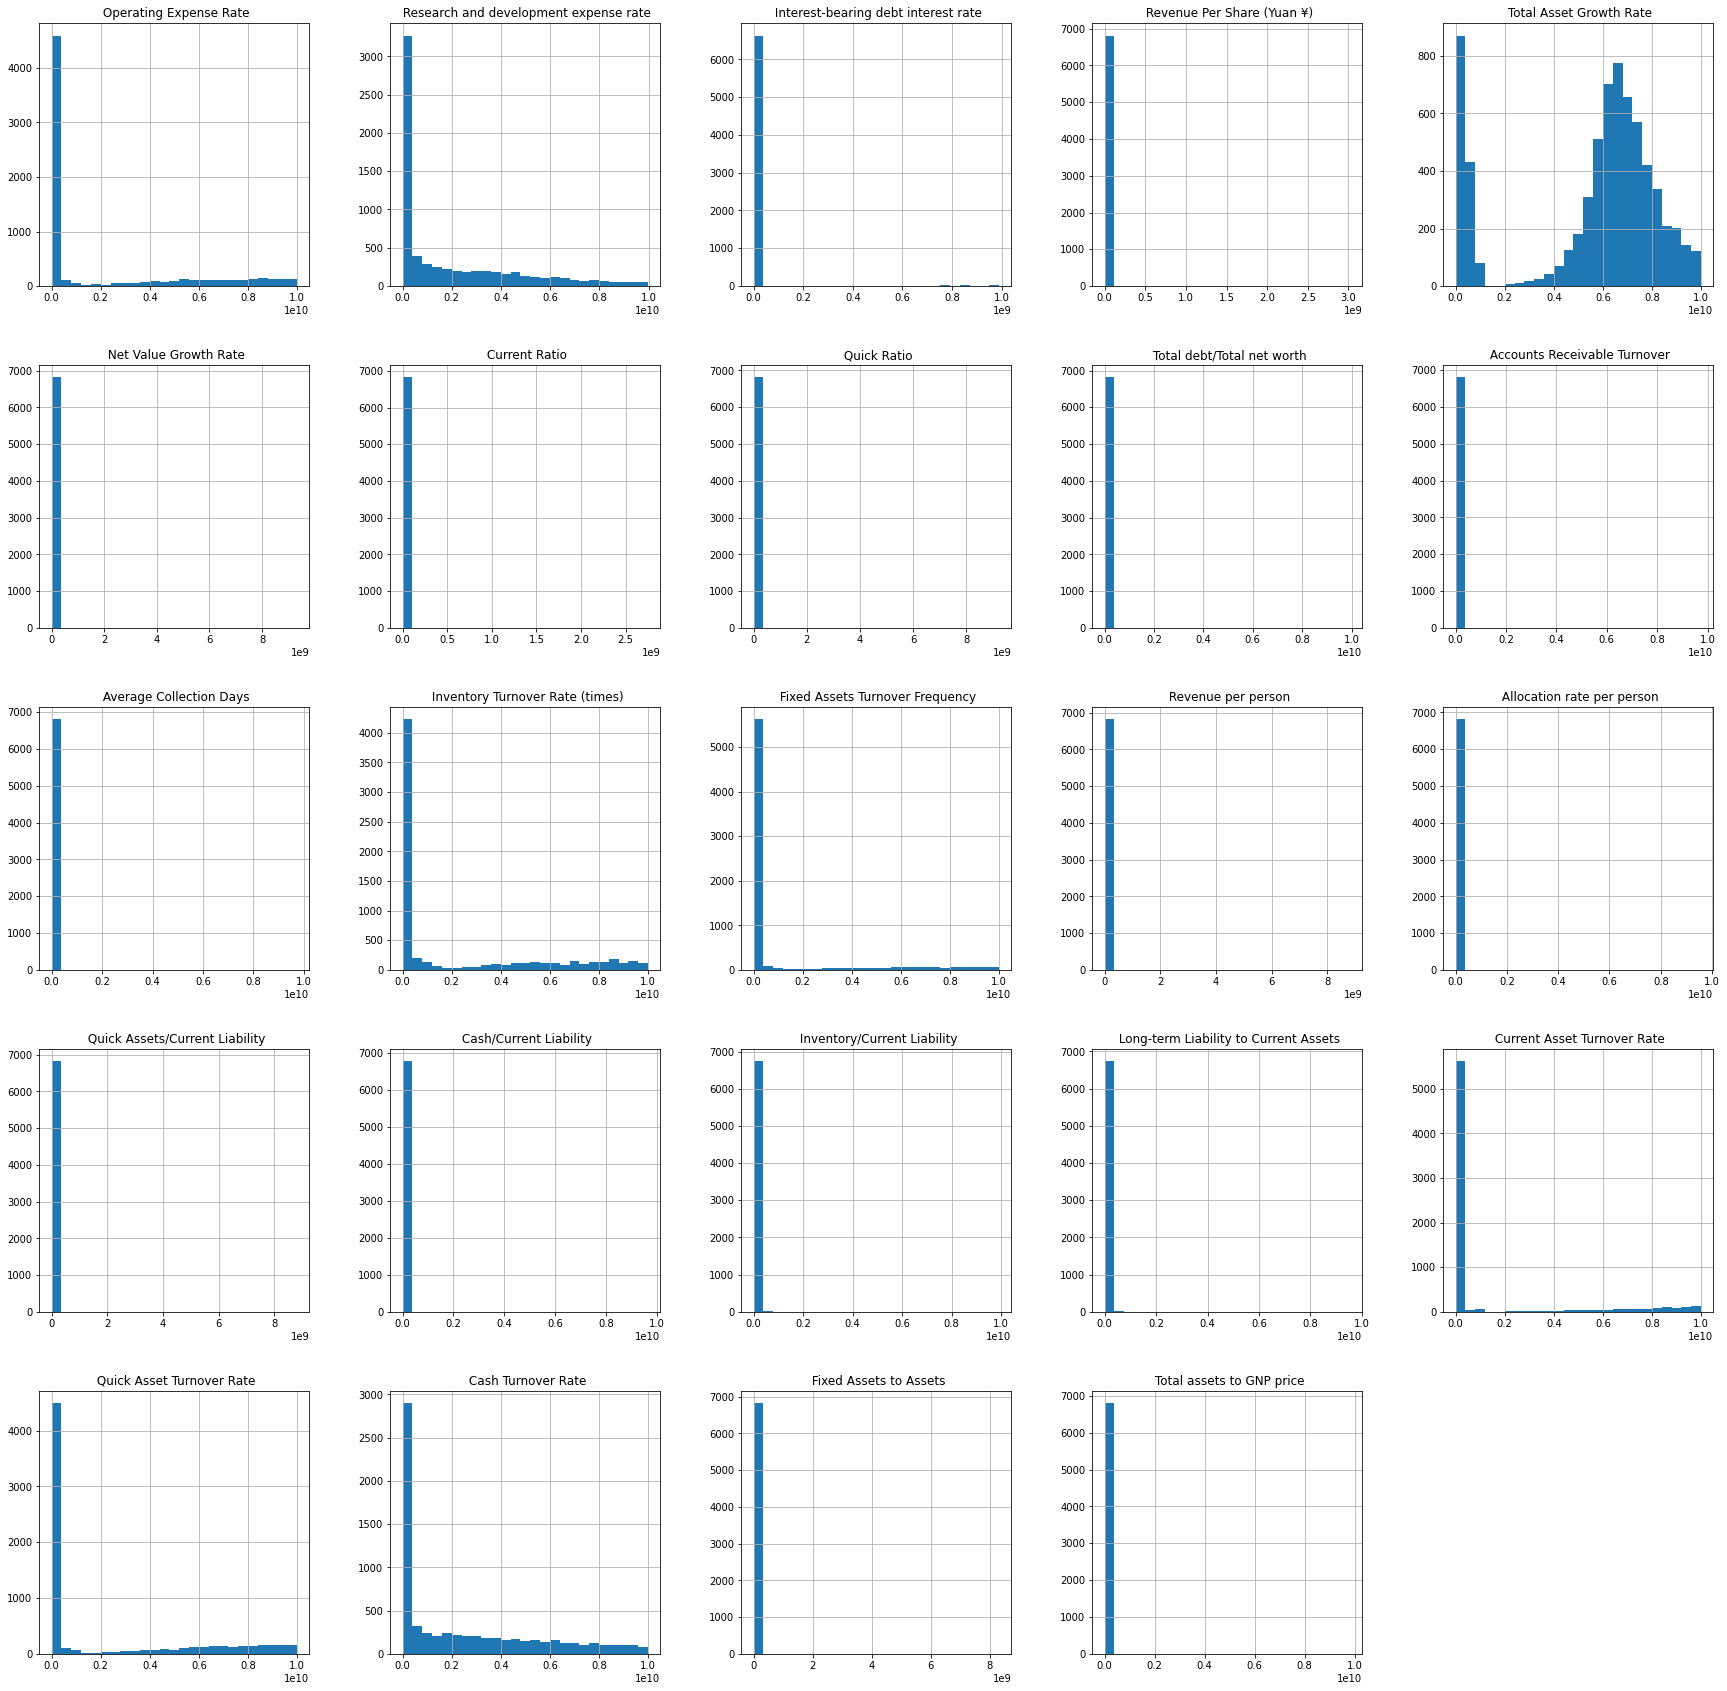

In [ ]:
#Distribution of features
df_v1.hist(bins=25,figsize = (30,30))

# SMOTE

In [ ]:
df.groupby('Bankrupt?')['Bankrupt?'].count()

Bankrupt?
0    6599
1     220
Name: Bankrupt?, dtype: int64

Observation:
* The dataset contains unbalanced classes. This issue can be resolved by using SMOTE technique

In [ ]:
X_new = df[required_features] #Taking the required independent variables
y_new = df['Bankrupt?'] #Dependent variable

#Initializing SMOTE
sm = SMOTE(random_state=22)
X_smote,y_smote = sm.fit_sample(X_new,y_new)

In [ ]:
count_class = Counter(y_smote)
print(count_class)
temp=pd.DataFrame(y_smote)

Counter({1: 6599, 0: 6599})


Text(0, 0.5, 'No. of Comapnies')

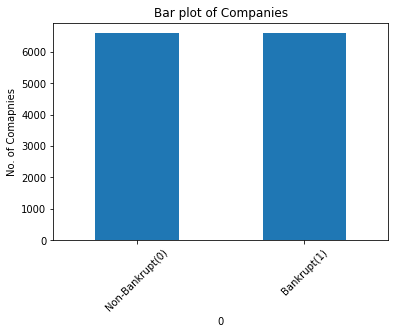

In [ ]:
temp.value_counts().plot(kind="bar")
plt.title("Bar plot of Companies")
plt.xticks([0,1],["Non-Bankrupt(0)","Bankrupt(1)"],rotation = 45)
plt.ylabel("No. of Comapnies")

# Model selection and building

In [ ]:
#Splitting training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.3, random_state=42)

In [ ]:
my_models = {
    'SVM':{'model':svm.SVC(gamma='auto',C=5,kernel='rbf'),'params': {'C': [1,5,10]}},
    'xgboost':{'model':xgb.XGBClassifier(),'params': {'max_depth':[4,6,8]}},
    'random_forest': {'model': RandomForestClassifier(),'params': {'n_estimators': [1,5]}},
    'logistic_regression' : {'model': LogisticRegression(solver='liblinear',multi_class='auto'),'params': {'C': [1,5]}},
    'naive_bayes_gaussian': {'model': GaussianNB(),'params': {}},
    'decision_tree': {'model': DecisionTreeClassifier(),'params': {'criterion': ['gini','entropy']}}
}

In [ ]:
scores = []

for model_name, mp in my_models.items():
    clf =  GridSearchCV(mp['model'],mp['params'] ,cv= 2, return_train_score=False)
    clf.fit(X_smote, y_smote)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_model = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_model

,model,best_score,best_params
0,SVM,0.509926,{'C': 1}
1,xgboost,0.944916,{'max_depth': 8}
2,random_forest,0.927641,{'n_estimators': 5}
3,logistic_regression,0.554251,{'C': 1}
4,naive_bayes_gaussian,0.520155,{}
5,decision_tree,0.912563,{'criterion': 'gini'}


<font color="yellow">Xgboost classifier performs well than other models !

In [ ]:
#Xgboost classifier
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train,y_train)
ypred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test,ypred_xgb))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      2005
           1       0.94      0.97      0.95      1955

    accuracy                           0.95      3960
   macro avg       0.95      0.95      0.95      3960
weighted avg       0.95      0.95      0.95      3960



In [ ]:
print(accuracy_score(y_test,ypred_xgb))

0.9542929292929293


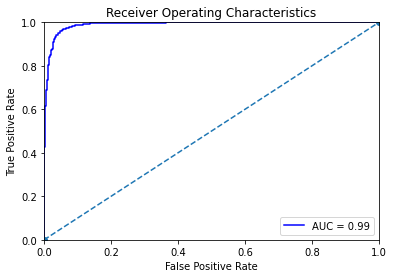

In [ ]:
from sklearn.metrics import accuracy_score,roc_curve,classification_report,roc_curve,auc
probs = xgb_model.predict_proba(X_test) #extracting the probabilities out of the model predictor
preds = probs[:,1] 
fpr, tpr, threshold = roc_curve(y_test, preds) #calculating the fpr and tpr along with threshold
roc_auc = auc(fpr, tpr) 

plt.title('Receiver Operating Characteristics')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc) #plotting, putting label as AUC
plt.legend(loc = 'lower right')#placing legend

plt.plot([0, 1], [0, 1],'o--') #plotting the dumb classifier line

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()